In [1]:
import matplotlib.pyplot as plt

import numpy as np

import sympy as sym

from cobra import DictList

from mass import (
    io, MassMetabolite, MassReaction, MassModel, Simulation, plot_simulation, qcqa_model)

## Model Construction

In [2]:
# Load example models
glycolysis = io.json.load_json_model("../../test-models/json-models/glycolysis.json")
ppp = io.json.load_json_model("../../test-models/json-models/pentose_phosphate_pathway.json")
ampsn = io.json.load_json_model("../../test-models/json-models/amp_salvage_network.json")
hemoglobin = io.json.load_json_model("../../test-models/json-models/hemoglobin.json")

# Create merged model of glycolysis and the pentose phosphate pathway
textbook = glycolysis.merge(ppp, inplace=False)
textbook.modules.add(glycolysis.id)
# Add in AMP salvage network
textbook.merge(ampsn, inplace=True)
# Remove uncessesary exchanges
textbook.remove_reactions([r for r in textbook.exchanges 
                             if r.id in ["EX_g6p_e", "DM_f6p_e", "DM_g3p_e", "DM_r5p_e",
                                         "DM_amp_e", "S_amp_e", "EX_amp_e"]])
textbook.remove_fixed_concentrations([
    met for met in textbook.fixed_concentrations
    if met not in textbook.external_metabolites])
# Adjust stoichiometry and rate constant for PRPPS 
textbook.reactions.PRPPS.subtract_metabolites({textbook.metabolites.atp_c: -1,
                                                   textbook.metabolites.adp_c: 2})
textbook.reactions.PRPPS.add_metabolites({textbook.metabolites.amp_c: 1})
# Add in hemoglobin module 
textbook.merge(hemoglobin, inplace=True, new_model_id="Core_RBC_Model")

Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_h2o_e' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_h2o_e' since it already exists.


Name,Core_RBC_Model
Memory address,0x01206e9e80
Stoichiometric Matrix,48x53
Matrix Rank,44
Matrix Type,"dense, float64"
Number of Metabolites,48
Number of Reactions,53
Number of Initial Conditions,48
Number of Forward Rate Constants,53
Number of Equilibrium Constants,53
Number of Irreversible Reactions,11


## Steady State Determination

In [3]:
# Minspan paths
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])

# Define new order for reactions
new_metabolite_order = ["glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c","g3p_c", 
                        "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", 
                        "_6pgl_c", "_6pgc_c", "ru5p__D_c",  "xu5p__D_c", "r5p_c", 
                        "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c", 
                        "r1p_c", "prpp_c", "_23dpg_c","hb_c", "hb_1o2_c", "hb_2o2_c", 
                        "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c", 
                        "adp_c", "atp_c", "nadp_c", "nadph_c", "gthrd_c", "gthox_c", 
                        "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
if len(textbook.metabolites) == len(new_metabolite_order):
    textbook.metabolites = DictList(textbook.metabolites.get_by_any(new_metabolite_order))
# Define new order for metabolites
new_reaction_order = ["HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", 
                      "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE", 
                      "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", 
                      "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", "DPGM", 
                      "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM", 
                      "DM_nadh","GTHOr", "GSHR", "S_glc__D_e", "EX_pyr_e", "EX_lac__L_e",
                      "EX_ade_e", "EX_adn_e", "EX_ins_e", "EX_hxan_e","EX_pi_e", 
                      "EX_h_e", "EX_h2o_e", "EX_co2_e", "EX_nh3_e", "EX_o2_e"]
if len(textbook.reactions) == len(new_reaction_order):
    textbook.reactions = DictList(textbook.reactions.get_by_any(new_reaction_order))
    
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {textbook.reactions.S_glc__D_e: 1.12, 
                      textbook.reactions.DM_nadh: 0.2*1.12, 
                      textbook.reactions.GSHR : 0.42, 
                      textbook.reactions.EX_ade_e: -0.014, 
                      textbook.reactions.ADA: 0.01,
                      textbook.reactions.EX_adn_e: -0.01, 
                      textbook.reactions.ADNK1: 0.12, 
                      textbook.reactions.EX_hxan_e: 0.097, 
                      textbook.reactions.DPGM: 0.441}

# Compute steady state fluxes
textbook.compute_steady_state_fluxes(minspan_paths, 
                                     independent_fluxes, 
                                     update_reactions=True);

# Calculation of PERCs
textbook.calculate_PERCs(update_reactions=True);
textbook.reactions.EX_o2_e.kf = 509726
textbook.reactions.HBDPG.kf =519613
textbook.reactions.HBO1.kf = 506935
textbook.reactions.HBO2.kf = 511077
textbook.reactions.HBO3.kf = 509243
textbook.reactions.HBO4.kf = 501595

## Steady State Validation

In [4]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(textbook)
sim.find_steady_state_model(model=textbook, strategy="simulate", 
                            update_initial_conditions=True, 
                            update_reactions=True)

(<Solution Core_RBC_Model_ConcSol at 0x120501f10>,
 <Solution Core_RBC_Model_FluxSol at 0x122bdff68>)

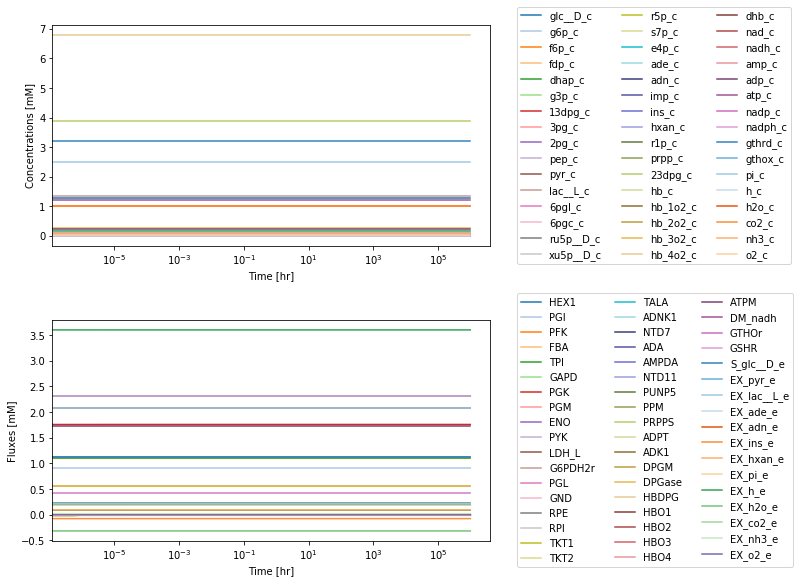

In [5]:
t0, tf = (0, 1e6)
conc_sol, flux_sol = sim.simulate_model(textbook, time=(t0, tf))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 8), 
                               constrained_layout=True);

plot_simulation(conc_sol, ax=ax1, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Concentrations [mM]");

plot_simulation(flux_sol, ax=ax2, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Fluxes [mM]");

In [6]:
io.json.save_json_model(textbook, "../../test-models/json-models/textbook.json")
# io.sbml.write_sbml_model(textbook, "../../test-models/sbml-models/textbook.xml")